<a href="https://colab.research.google.com/github/emilyhoughkovacs/splice/blob/main/CatBoostClassifier_model_one_hot_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data
The following three sections are part of the cookiecutter provided out-of-the-box when exporting data from BigQuery to a python notebook. Jump to "Prepare data to be ready to use in model" for my analysis.

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'emily-hk' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=emily-hk:US:bquxjob_1c159ffa_18dd7de1034)
back to BigQuery to edit the query within the BigQuery user interface.

In [2]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_5306aba3_18de268c6c3') # Job ID inserted based on the query results selected to explore
print(job.query)

with browsers as (SELECT 
  device.browser,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by 1
order by 2 desc
limit 3),
oses as (SELECT 
  device.operatingSystem,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by 1
order by 2 desc
limit 5),
countries as (SELECT 
  geoNetwork.country,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by 1
order by 2 desc
LIMIT 10),
lp as (SELECT 
  if(h.page.pagePath LIKE '/google+redesign/apparel%', '/google+redesign/apparel', h.page.pagePath) as landing_page,
  count(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, unnest(hits) h
where isEntrance is true
group by 1
order by 2 desc
LIMIT 5
),
visits_landing_page as (SELECT
  CONCAT(fullVisitorId, "-", visitId, "-", date) as unique_session_id,
  if(h.page.pagePath LIKE '/google+redesign/apparel%', '/google+redesign/apparel', h.page.pagePath) as landing_page
  FROM `bigquery-pub

## Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [3]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_5306aba3_18de268c6c3') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,unique_session_id,hits,pageviews,medium,browser,operatingSystem,country,landing_page,is_transaction
0,8597222891158829963-1477761593-20161029,53,33,(none),Safari,iOS,United States,Other,0
1,847183914353283820-1474211709-20160918,22,20,organic,Chrome,Other,Other,/home,0
2,6408592838060313017-1471536336-20160818,94,64,(none),Chrome,Windows,United States,/home,1
3,0689482657554164004-1500638351-20170721,35,28,organic,Chrome,Android,Other,/home,0
4,3098102694893246712-1498839677-20170630,52,36,organic,Other,Windows,United States,/google+redesign/apparel,1
...,...,...,...,...,...,...,...,...,...
903548,2401141511008437892-1486135052-20170203,16,13,(none),Chrome,Macintosh,United States,/google+redesign/apparel,0
903549,9148627782134822389-1485327977-20170124,16,12,cpm,Chrome,Macintosh,United States,/home,0
903550,0066593530542228662-1484061450-20170110,16,15,(none),Chrome,Macintosh,United States,/home,0
903551,5483474169242977077-1486122335-20170203,16,16,(none),Chrome,Android,United States,/home,0


# Prepare data to be ready to use in model

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [5]:
df = results.drop('unique_session_id', axis=1)

In [6]:
df.shape

(903553, 8)

In [7]:
y = df['is_transaction']
X = df.drop(['is_transaction'], axis=1)

In [8]:
X.dtypes

hits                Int64
pageviews           Int64
medium             object
browser            object
operatingSystem    object
country            object
landing_page       object
dtype: object

In [9]:
X_onehot = pd.get_dummies(X[['medium', 'browser', 'operatingSystem', 'country', 'landing_page']])

In [10]:
X_onehot.dtypes

medium_(none)                                          uint8
medium_(not set)                                       uint8
medium_affiliate                                       uint8
medium_cpc                                             uint8
medium_cpm                                             uint8
medium_organic                                         uint8
medium_referral                                        uint8
browser_Chrome                                         uint8
browser_Firefox                                        uint8
browser_Other                                          uint8
browser_Safari                                         uint8
operatingSystem_Android                                uint8
operatingSystem_Linux                                  uint8
operatingSystem_Macintosh                              uint8
operatingSystem_Other                                  uint8
operatingSystem_Windows                                uint8
operatingSystem_iOS     

In [11]:
X_onehot = X_onehot.drop(['medium_(not set)', 'browser_Other', 'operatingSystem_Other', 'country_Other', 'landing_page_Other'], axis=1)

In [12]:
X_onehot.dtypes

medium_(none)                                          uint8
medium_affiliate                                       uint8
medium_cpc                                             uint8
medium_cpm                                             uint8
medium_organic                                         uint8
medium_referral                                        uint8
browser_Chrome                                         uint8
browser_Firefox                                        uint8
browser_Safari                                         uint8
operatingSystem_Android                                uint8
operatingSystem_Linux                                  uint8
operatingSystem_Macintosh                              uint8
operatingSystem_Windows                                uint8
operatingSystem_iOS                                    uint8
country_Brazil                                         uint8
country_Canada                                         uint8
country_Germany         

In [13]:
X_encoded = pd.concat([X[['hits', 'pageviews']], X_onehot], axis=1)

In [14]:
X_encoded.columns

Index(['hits', 'pageviews', 'medium_(none)', 'medium_affiliate', 'medium_cpc',
       'medium_cpm', 'medium_organic', 'medium_referral', 'browser_Chrome',
       'browser_Firefox', 'browser_Safari', 'operatingSystem_Android',
       'operatingSystem_Linux', 'operatingSystem_Macintosh',
       'operatingSystem_Windows', 'operatingSystem_iOS', 'country_Brazil',
       'country_Canada', 'country_Germany', 'country_India', 'country_Japan',
       'country_Thailand', 'country_Turkey', 'country_United Kingdom',
       'country_United States', 'country_Vietnam', 'landing_page_/basket.html',
       'landing_page_/google+redesign/apparel',
       'landing_page_/google+redesign/shop+by+brand/youtube',
       'landing_page_/home', 'landing_page_/signin.html'],
      dtype='object')

In [15]:
X_encoded.shape

(903553, 31)

In [16]:
y.shape

(903553,)

# Set up and train the CatBoost model
For the sake of simplicity, I'm still using the CatBoostClassifier even though I've encoded the variables.

In [17]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.5 MB/s eta 0:00:00


In [19]:
from catboost import CatBoostClassifier
from catboost import Pool

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=13)

In [20]:
clf = CatBoostClassifier()

In [22]:
clf.fit(X_train, y=y_train)

Learning rate set to 0.171295
0:	learn: 0.3102831	total: 368ms	remaining: 6m 7s
1:	learn: 0.1434253	total: 698ms	remaining: 5m 48s
2:	learn: 0.0777701	total: 1.03s	remaining: 5m 42s
3:	learn: 0.0538052	total: 1.47s	remaining: 6m 6s
4:	learn: 0.0416447	total: 1.73s	remaining: 5m 44s
5:	learn: 0.0363715	total: 2.02s	remaining: 5m 35s
6:	learn: 0.0346439	total: 2.31s	remaining: 5m 27s
7:	learn: 0.0326173	total: 2.57s	remaining: 5m 19s
8:	learn: 0.0314883	total: 2.78s	remaining: 5m 6s
9:	learn: 0.0312273	total: 3.04s	remaining: 5m
10:	learn: 0.0308723	total: 3.34s	remaining: 5m
11:	learn: 0.0306887	total: 3.69s	remaining: 5m 4s
12:	learn: 0.0305361	total: 3.94s	remaining: 4m 59s
13:	learn: 0.0304100	total: 4.23s	remaining: 4m 58s
14:	learn: 0.0303389	total: 4.51s	remaining: 4m 55s
15:	learn: 0.0302053	total: 4.79s	remaining: 4m 54s
16:	learn: 0.0298446	total: 5.02s	remaining: 4m 50s
17:	learn: 0.0296806	total: 5.29s	remaining: 4m 48s
18:	learn: 0.0296070	total: 5.66s	remaining: 4m 52s
19:	

# Get feature importance

In [23]:
feature_importances = clf.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

print("Feature importances:")
for f in range(len(feature_names)):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], feature_importances[indices[f]]))

Feature importances:
1. feature country_United States (29.687569)
2. feature pageviews (22.183705)
3. feature landing_page_/home (11.221872)
4. feature hits (6.624991)
5. feature medium_referral (4.273962)
6. feature medium_(none) (3.924712)
7. feature operatingSystem_Android (2.407961)
8. feature browser_Chrome (2.132825)
9. feature operatingSystem_Macintosh (2.080007)
10. feature landing_page_/google+redesign/shop+by+brand/youtube (1.953664)
11. feature landing_page_/google+redesign/apparel (1.903257)
12. feature country_Japan (1.413960)
13. feature browser_Safari (1.344882)
14. feature operatingSystem_Windows (1.064028)
15. feature operatingSystem_iOS (1.027698)
16. feature medium_organic (0.893466)
17. feature browser_Firefox (0.708229)
18. feature medium_affiliate (0.637028)
19. feature country_United Kingdom (0.568594)
20. feature country_Canada (0.566994)
21. feature landing_page_/basket.html (0.535118)
22. feature country_Germany (0.506822)
23. feature country_India (0.467149)


## Pageviews

In [21]:
from scipy import stats

In [22]:
converting_pageviews = list(df.loc[df['is_transaction']==1, 'pageviews'])
non_converting_pageviews = list(df.loc[df['is_transaction']==0, 'pageviews'])

In [23]:
converting_pageviews = list(X_train.loc[y_train==1, 'pageviews'])
non_converting_pageviews = list(X_train.loc[y_train==0, 'pageviews'])

In [24]:
t_statistic, p_value = stats.ttest_ind(converting_pageviews, non_converting_pageviews, equal_var = False)

In [25]:
alpha = 0.05

In [26]:
# Print results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the average pageviews of converting and non-converting sessions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the average pageviews of converting and non-converting sessions.")

t-statistic: 111.59285128973087
p-value: 0.0
Reject the null hypothesis. There is a significant difference between the average pageviews of converting and non-converting sessions.


In [27]:
avg_converting_pvs = np.mean(converting_pageviews)
avg_non_converting_pvs = np.mean(non_converting_pageviews)

std_converting_pvs = np.std(converting_pageviews)
std_non_converting_pvs = np.std(non_converting_pageviews)

In [28]:
data = {
    'average converting pageviews' : [avg_converting_pvs, std_converting_pvs],
    'average non-converting pageviews': [avg_non_converting_pvs, std_non_converting_pvs]
}

In [29]:
pd.DataFrame(data)

,average converting pageviews,average non-converting pageviews
0,28.258464,3.531435
1,21.259900,5.983742


In [30]:
print("average converting pageviews:", avg_converting_pvs)
print("average non-converting pageviews:", avg_non_converting_pvs)

average converting pageviews: 28.258463541666668
average non-converting pageviews: 3.5314352335817363


In [41]:
import matplotlib.pyplot as plt

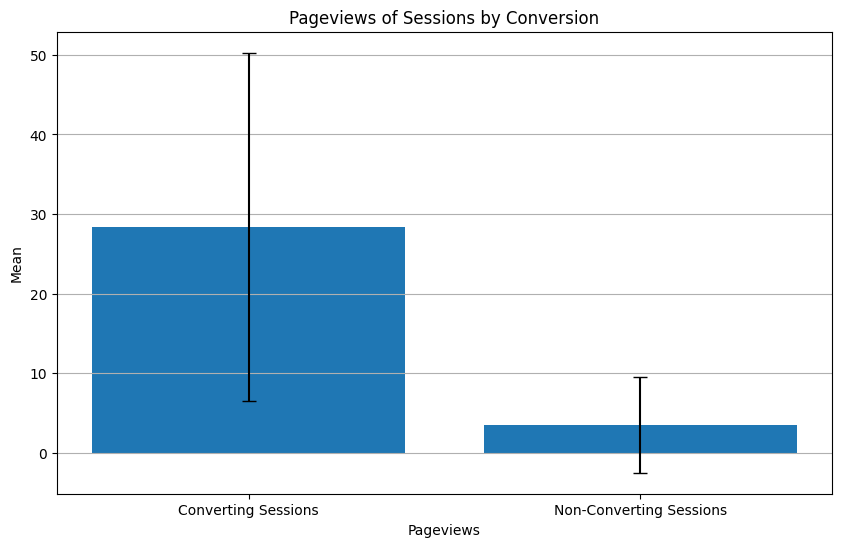

The means of the two datasets are statistically significantly different (reject null hypothesis).


In [81]:
# Plot the datasets
plt.figure(figsize=(10, 6))
plt.bar([1, 2], [avg_converting_pvs, avg_non_converting_pvs], yerr=[std_converting_pvs, std_non_converting_pvs], tick_label=['Converting Sessions', 'Non-Converting Sessions'], capsize=5)
plt.xlabel('Pageviews')
plt.ylabel('Mean')
plt.title('Pageviews of Sessions by Conversion')
plt.grid(axis='y')
plt.show()

# Perform t-test
t_statistic, p_value = stats.ttest_ind(converting_pageviews, non_converting_pageviews, equal_var = False)
alpha = 0.05
if p_value < alpha:
    print("The means of the two datasets are statistically significantly different (reject null hypothesis).")
else:
    print("The means of the two datasets are not statistically significantly different (fail to reject null hypothesis).")

Dataset 1:
Box: [16. 16. 34. 34. 16.]
Whiskers: [array([16.,  2.]), array([34., 61.])]
Medians: [23. 23.]

Dataset 2:
Box: [1. 1. 3. 3. 1.]
Whiskers: [array([1., 1.]), array([3., 6.])]
Medians: [1. 1.]



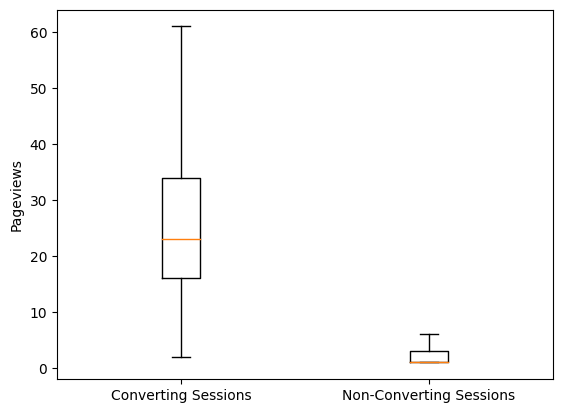

In [82]:

# boxplot comparing converting sessions and non-converting sessions by pageviews
boxplot = plt.boxplot([converting_pageviews, non_converting_pageviews], showfliers=False)

# Extracting statistics
statistics = []
for i in range(2):
    box = boxplot['boxes'][i]
    whiskers = boxplot['whiskers'][i * 2: (i + 1) * 2]
    medians = boxplot['medians'][i]
    statistics.append({
        'box': box.get_ydata(),
        'whiskers': [whiskers[j].get_ydata() for j in range(2)],
        'medians': medians.get_ydata(),
      #  'fliers': [flier.get_ydata() for flier in boxplot['fliers'][i]],
    })

# Print statistics
for i, stats in enumerate(statistics):
    print(f'Dataset {i+1}:')
    print('Box:', stats['box'])
    print('Whiskers:', stats['whiskers'])
    print('Medians:', stats['medians'])
   # print('Fliers:', stats['fliers'])
    print()

#label plot
plt.ylabel('Pageviews')
plt.xticks([1, 2], ['Converting Sessions', 'Non-Converting Sessions'])

plt.show()

## country = United States

In [88]:
X_encoded

,hits,pageviews,medium_(none),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,browser_Chrome,browser_Firefox,...,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_Vietnam,landing_page_/basket.html,landing_page_/google+redesign/apparel,landing_page_/google+redesign/shop+by+brand/youtube,landing_page_/home,landing_page_/signin.html
0,20,16,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,18,15,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,20,10,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,74,56,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,45,32,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903548,16,12,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
903549,16,14,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
903550,16,14,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
903551,16,14,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0


In [110]:
convert_US = len(X_train[(X_train['country_United States']==1) & (y_train == 1)]['country_United States'])
convert_non_US = len(X_train[(X_train['country_United States']==0) & (y_train == 1)]['country_United States'])
total_US = len(X_train[X_train['country_United States']==1]['country_United States'])
total_non_US = len(X_train[X_train['country_United States']==0]['country_United States'])

In [106]:
def z_test_proportions(p1, n1, p2, n2):
    # Calculate proportions
    prop1 = p1 / n1
    prop2 = p2 / n2

    # Calculate pooled proportion
    p_pool = (p1 + p2) / (n1 + n2)

    # Calculate standard error
    se = np.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))

    # Calculate z-score
    z = (prop1 - prop2) / se

    # Calculate p-value
    p_value = stats.norm.sf(abs(z)) * 2

    return z, p_value

# Example usage
z_score, p_value = z_test_proportions(convert_US, total_US, convert_non_US, total_non_US)
print("Z-score:", z_score)
print("P-value:", p_value)

Z-score: 107.93945282789814
P-value: 0.0


In [109]:
print("US conversions:", convert_US/total_US*100)
print("Non-US conversions:", convert_non_US/total_non_US*100)

US conversions: 3.0082688826723714
Non-US conversions: 0.10390911663334462


## Landing page

In [111]:
convert_lp_home = len(X_train[(X_train['landing_page_/home']==1) & (y_train == 1)]['landing_page_/home'])
convert_non_lp_home = len(X_train[(X_train['landing_page_/home']==0) & (y_train == 1)]['landing_page_/home'])
total_lp_home = len(X_train[X_train['landing_page_/home']==1]['landing_page_/home'])
total_non_lp_home = len(X_train[X_train['landing_page_/home']==0]['landing_page_/home'])

In [113]:
z_score, p_value = z_test_proportions(convert_lp_home, total_lp_home, convert_non_lp_home, total_non_lp_home)
print("Z-score:", z_score)
print("P-value:", p_value)
print()
print("Landing Page = /home Conversions:", convert_lp_home/total_lp_home*100)
print("Landing Page != /home Conversions:", convert_non_lp_home/total_non_lp_home*100)

Z-score: -17.283875949722418
P-value: 6.22225261928571e-67

Landing Page = /home Conversions: 1.1200986806734794
Landing Page != /home Conversions: 1.6099922153266735


## Prediction analysis

In [114]:
predictions = clf.predict(X_test)

In [116]:
X_test_with_predictions = X_test.copy()

In [117]:
X_test_with_predictions['predictions'] = predictions

In [119]:
X_test_with_predictions.head()

,hits,pageviews,medium_(none),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,browser_Chrome,browser_Firefox,...,country_Turkey,country_United Kingdom,country_United States,country_Vietnam,landing_page_/basket.html,landing_page_/google+redesign/apparel,landing_page_/google+redesign/shop+by+brand/youtube,landing_page_/home,landing_page_/signin.html,predictions
412223,1,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
587464,2,2,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
547739,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32249,52,31,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
223720,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [121]:
conversion_segments = X_test_with_predictions.groupby('country_United States')['predictions'].mean()

In [122]:
conversion_segments.sort_values(ascending=False)

country_United States
1    0.013986
0    0.000158
Name: predictions, dtype: float64

In [123]:
conversion_lp_segments = X_test_with_predictions.groupby('landing_page_/home')['predictions'].mean()

In [124]:
conversion_lp_segments.sort_values(ascending=False)

landing_page_/home
0    0.009861
1    0.003828
Name: predictions, dtype: float64